In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

%matplotlib inline

In [14]:
sns.set_style("ticks")
sns.set_palette('muted')

In [2]:
data = pd.read_csv('csv/CAX_MortgageModeling_Train.csv')
dfx = pd.DataFrame(data)

In [3]:
# Check Shape
dfx.shape

(45642, 22)

In [4]:
#Checking Imbalances
Counter(dfx['RESULT'])

Counter({'FUNDED': 36023, 'NOT FUNDED': 9619})

In [5]:
#Checking for Zeros
dfx.isin([0]).any()

Unique_ID            False
MORTGAGE NUMBER      False
PROPERTY VALUE       False
MORTGAGE PAYMENT     False
GDS                   True
LTV                  False
TDS                   True
AMORTIZATION         False
MORTGAGE AMOUNT      False
RATE                 False
MORTGAGE PURPOSE     False
PAYMENT FREQUENCY    False
PROPERTY TYPE        False
TERM                 False
FSA                  False
AGE RANGE            False
GENDER               False
INCOME               False
INCOME TYPE          False
NAICS CODE           False
CREDIT SCORE          True
RESULT               False
dtype: bool

In [6]:
#Zero Counts
dfx[dfx[['GDS', 'TDS', 'CREDIT SCORE']] <= 0].count()

Unique_ID               0
MORTGAGE NUMBER         0
PROPERTY VALUE          0
MORTGAGE PAYMENT        0
GDS                   428
LTV                     0
TDS                    80
AMORTIZATION            0
MORTGAGE AMOUNT         0
RATE                    0
MORTGAGE PURPOSE        0
PAYMENT FREQUENCY       0
PROPERTY TYPE           0
TERM                    0
FSA                     0
AGE RANGE               0
GENDER                  0
INCOME                  0
INCOME TYPE             0
NAICS CODE              0
CREDIT SCORE         1176
RESULT                  0
dtype: int64

In [7]:
# Encode Target Variable
def encode_target(df):
    
    df['RESULT'] = df['RESULT'].replace({'NOT FUNDED': 0, 'FUNDED': 1})

    return df

dfx = encode_target(dfx)

In [8]:
dfx.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,...,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,...,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,1
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,...,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,1
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,...,Single Detached,6,M1N,35-39,Female,87000,2,72,709,1
3,CAX_Train_4,4,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,...,Single Detached,12,M2M,45-49,Male,300000,8,54,761,1
4,CAX_Train_5,5,350000,3342,29.59,80.00,34.85,360,592000.0,5.0,...,Single Detached,12,L7G,50-54,Male,147000,8,62,762,1


In [9]:
# Cleaning Function
def clean_data(df):
    
    # Set Index
    df = df.set_index('Unique_ID')
    
    # Drop Mortgage Number
    df = df.drop(['MORTGAGE NUMBER'], axis=1)
    
    # Add Property Value
    df['PROPERTY_VAL_DELTA'] = df['PROPERTY VALUE'] - (df['MORTGAGE AMOUNT'] / (df['LTV'] / 100))
    
    # Update Property Value per Competition
    df['PROPERTY VALUE'] = df['MORTGAGE AMOUNT'] / (df['LTV'] / 100)
    
    # Set Negative GDS Values to Zero, per Competition
    df['GDS'] = np.where(df['GDS'] < 0, 0, df['GDS'])
    
    # Split FSA & Encode Urban or Rural
    df_temp = df['FSA'].str.split('', n=3, expand=True)
    df_temp[2] = df_temp[2].astype(int)
    df_temp['URBAN'] = np.where(df_temp[2] > 0, 1, 0)
    df_temp.drop([0, 2, 3], axis=1, inplace=True)
    
    # Name Territory Column, drop old FSA column
    df_temp.rename(columns={1: 'TERRITORY'}, inplace=True)
    df = pd.concat([df, df_temp], axis=1)
    df = df.drop(['FSA'], axis=1)
    
    return df

df = clean_data(dfx)

In [10]:
# Drop Mortgage Amount & Property Value outliers
z_thresh = 3

def remove_outliers(df):
    
    df['mortgage_amt_z'] = zscore(df['MORTGAGE AMOUNT'])
    df['property_val_z'] = zscore(df['PROPERTY VALUE'])
    
    df = df[(df['property_val_z'] <= z_thresh) & (df['mortgage_amt_z'] <= z_thresh)]
    df = df.drop(['mortgage_amt_z', 'property_val_z'], axis=1)
    
    df = df[(df['RATE'] < 9) & (df['RATE'] > 2.5)]
    
    df = df[(df['LTV'] < 200)]
    
    df = df[(df['TDS'] < 160)]
    
    df = df[(df['GDS'] < 160)]
    
    return df

df = remove_outliers(df)
df['RESULT'].value_counts()
print(f'Total Observations: {len(df)}')

1    35214
0     9273
Name: RESULT, dtype: int64

Total Observations: 44487


In [11]:
# Check degree of Imbalance after Cleaning
Counter(dfx['RESULT'])
df['RESULT'].value_counts(normalize=True)

Counter({1: 36023, 0: 9619})

1    0.791557
0    0.208443
Name: RESULT, dtype: float64

## EDA

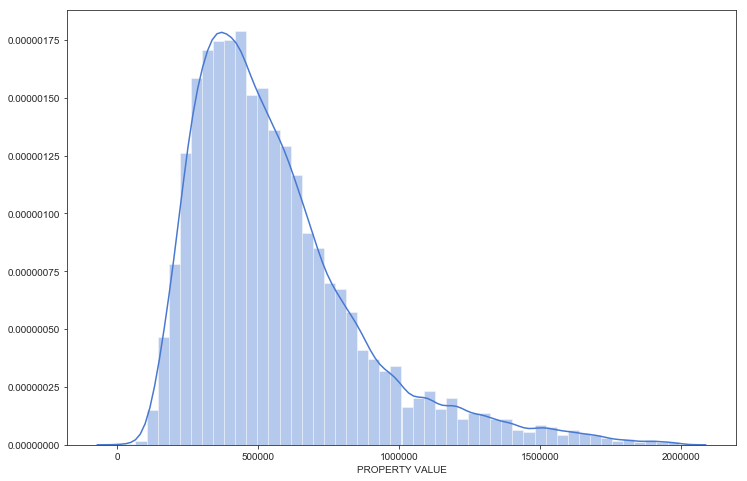

In [15]:
# Histogram of Property Value
plt.figure(figsize=(12,8))
sns.distplot(df['PROPERTY VALUE']);

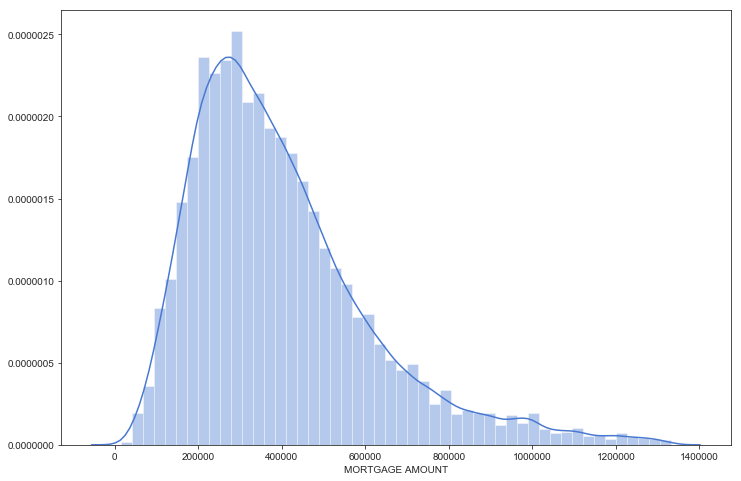

In [16]:
# Histogram of Property Value
plt.figure(figsize=(12,8))
sns.distplot(df['MORTGAGE AMOUNT']);

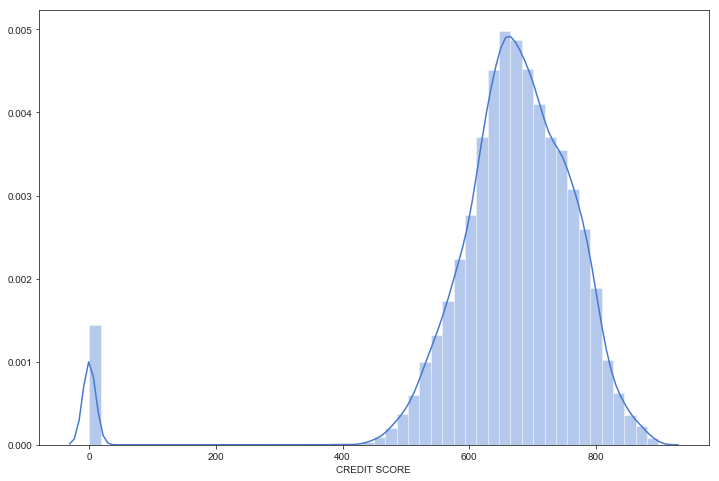

In [17]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

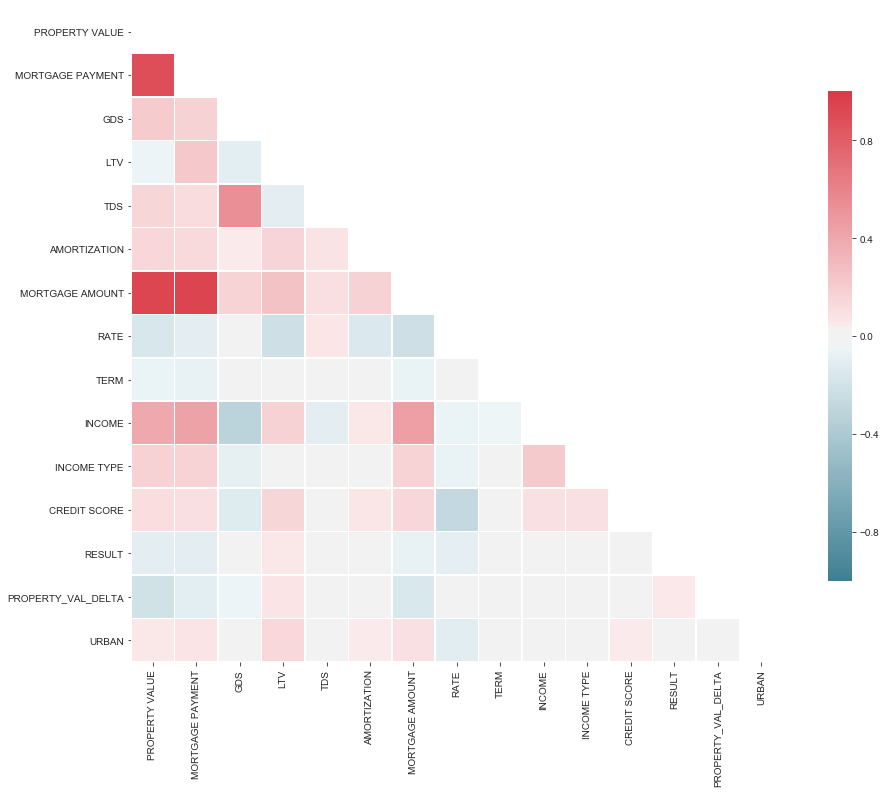

In [17]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [18]:
df.describe()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,RESULT,PROPERTY_VAL_DELTA,URBAN
count,4.448700e+04,44487.000000,44487.000000,44487.000000,44487.000000,44487.000000,4.448700e+04,44487.000000,44487.000000,4.448700e+04,44487.000000,44487.000000,44487.000000,4.448700e+04,44487.000000
mean,5.648201e+05,2240.545867,27.481269,70.811325,37.795431,355.283566,3.981144e+05,4.638574,15.331580,1.189924e+05,5.272709,661.885023,0.791557,-2.260484e+04,0.952840
std,3.037562e+05,1193.658180,13.504824,11.415159,11.194839,18.023297,2.170163e+05,0.617113,7.470188,9.660406e+04,3.277934,133.013607,0.406200,1.127747e+05,0.211983
min,2.612277e+04,141.000000,0.000000,6.667000,-10.700000,60.000000,1.500000e+04,2.750000,6.000000,2.000000e+03,-1.000000,0.000000,0.000000,-1.550007e+06,0.000000
25%,3.500000e+05,1395.000000,19.690000,65.000000,32.750000,360.000000,2.440000e+05,4.250000,12.000000,6.800000e+04,2.000000,622.000000,1.000000,-1.633333e+04,1.000000
50%,4.950495e+05,2007.000000,29.070000,75.000000,38.200000,360.000000,3.520000e+05,4.500000,12.000000,9.600000e+04,6.000000,676.000000,1.000000,0.000000e+00,1.000000
75%,6.980000e+05,2799.000000,35.750000,80.000000,42.050000,360.000000,5.000000e+05,5.000000,12.000000,1.400000e+05,8.000000,735.000000,1.000000,7.499981e+00,1.000000
max,1.990000e+06,11464.000000,156.520000,95.000000,158.770000,480.000000,1.331250e+06,8.500000,60.000000,2.400000e+06,20.000000,899.000000,1.000000,8.775000e+06,1.000000


In [19]:
df.corr()['RESULT'].sort_values(ascending=False)

RESULT                1.000000
LTV                   0.058078
PROPERTY_VAL_DELTA    0.047583
URBAN                 0.018975
TERM                  0.017955
CREDIT SCORE          0.016937
AMORTIZATION          0.013647
INCOME TYPE           0.000689
INCOME               -0.010253
GDS                  -0.020889
TDS                  -0.036092
MORTGAGE AMOUNT      -0.071984
RATE                 -0.087164
MORTGAGE PAYMENT     -0.096476
PROPERTY VALUE       -0.097835
Name: RESULT, dtype: float64

In [20]:
#sns.pairplot(df);

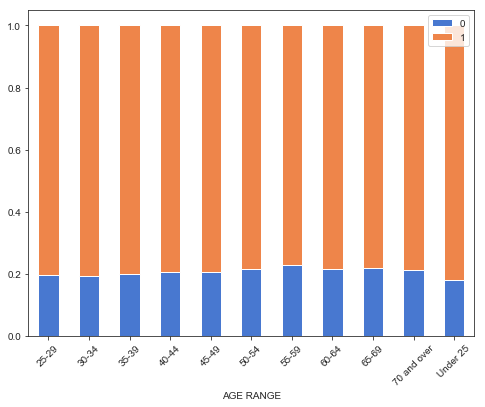

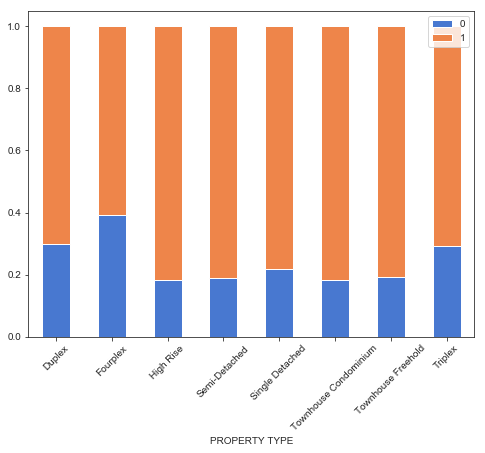

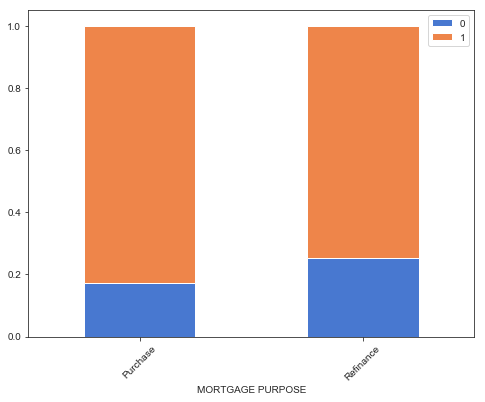

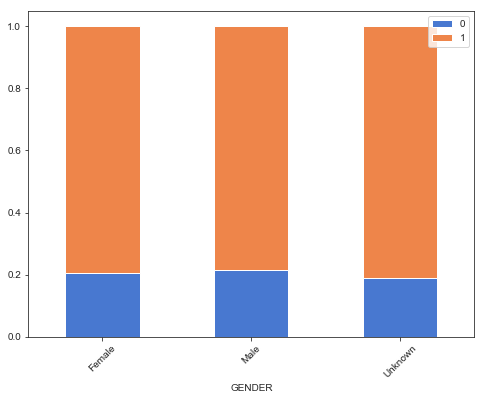

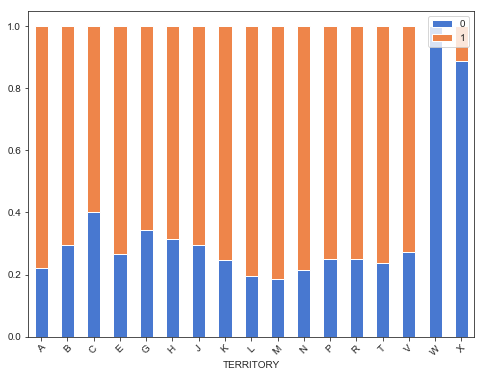

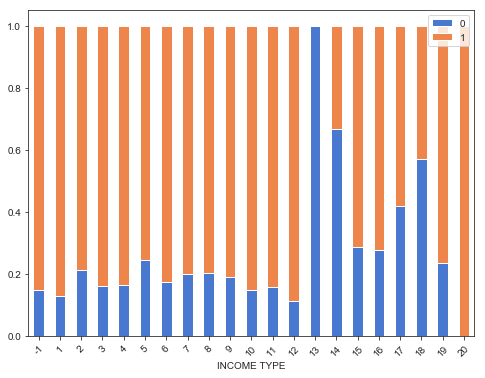

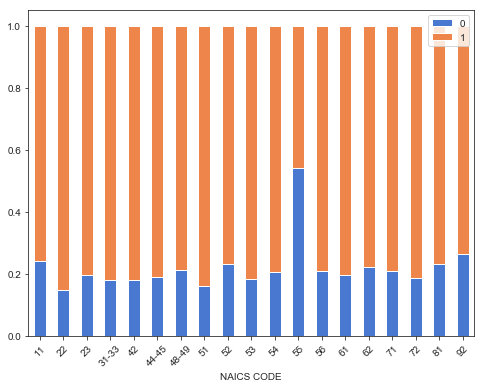

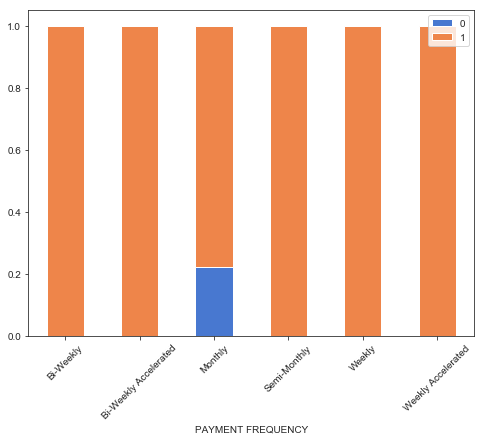

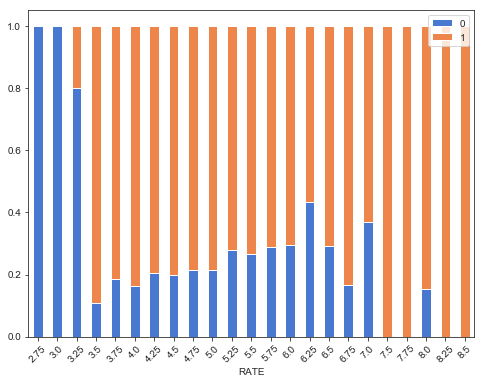

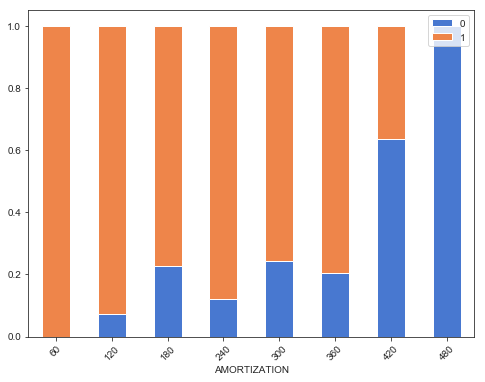

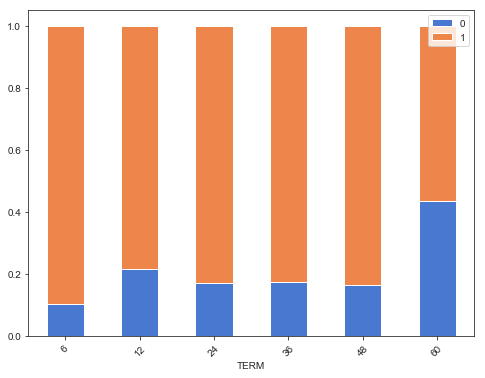

In [21]:
def stacked_bar_plot(col_1, col_2):
    
    x = df.groupby(col_1)[col_2].value_counts(normalize=True).unstack()
    x.plot(kind='bar', stacked='True', figsize=(8,6))
    plt.legend(loc=1)
    plt.xticks(rotation=45)
    plt.show();

    
stack_list = ['AGE RANGE', 'PROPERTY TYPE', 'MORTGAGE PURPOSE', 'GENDER', 'TERRITORY', \
                'INCOME TYPE', 'NAICS CODE', 'PAYMENT FREQUENCY', 'RATE', 'AMORTIZATION', 'TERM']

for feature in stack_list:
    
    stacked_bar_plot(feature, 'RESULT')


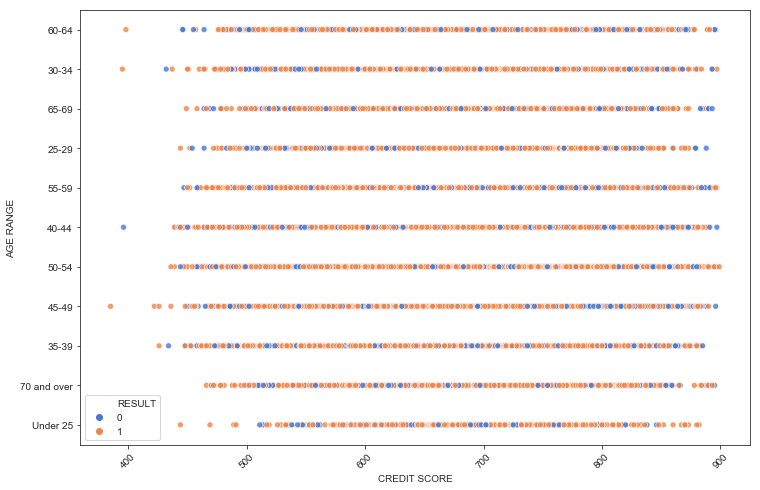

In [22]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, alpha=.8)
    plt.xticks(rotation=45)
    plt.show();

scatter_plot('CREDIT SCORE', 'AGE RANGE', 'RESULT', df[df['CREDIT SCORE'] > 0])

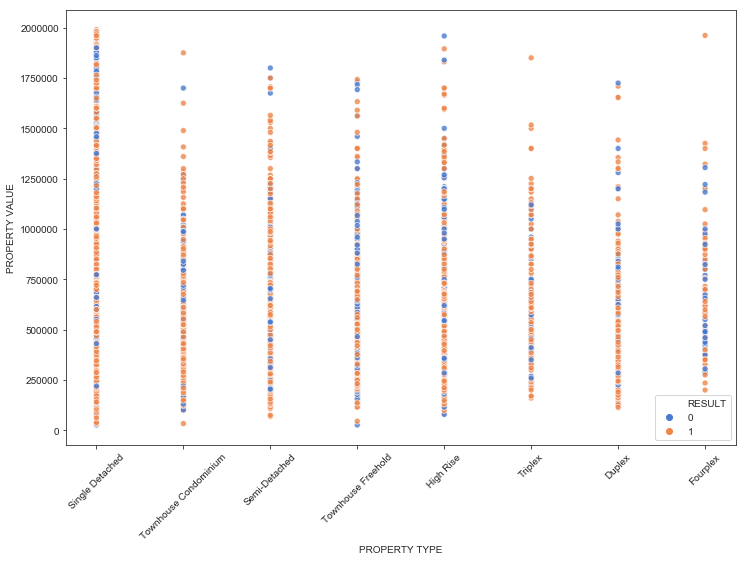

In [23]:
scatter_plot('PROPERTY TYPE', 'PROPERTY VALUE', 'RESULT', df)

In [24]:
Counter(dfx['PROPERTY TYPE'])

Counter({'Single Detached': 29377,
         'Townhouse Condominium': 2309,
         'Semi-Detached': 4227,
         'Townhouse Freehold': 3040,
         'High Rise': 5909,
         'Triplex': 193,
         'Duplex': 469,
         'Fourplex': 118})

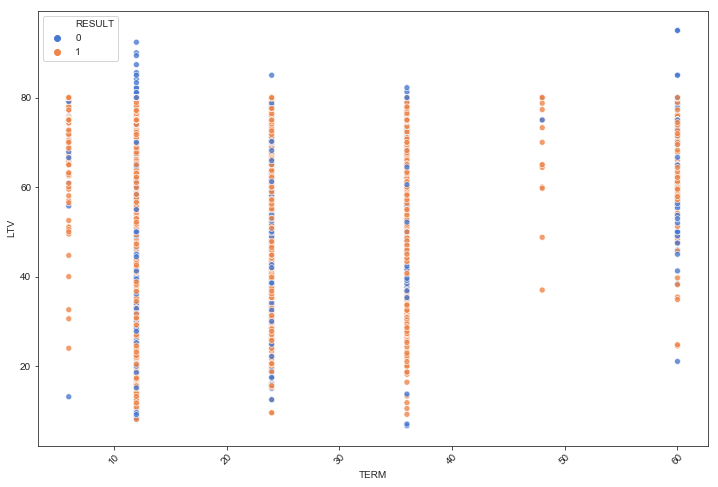

In [25]:
scatter_plot('TERM', 'LTV', 'RESULT', df)

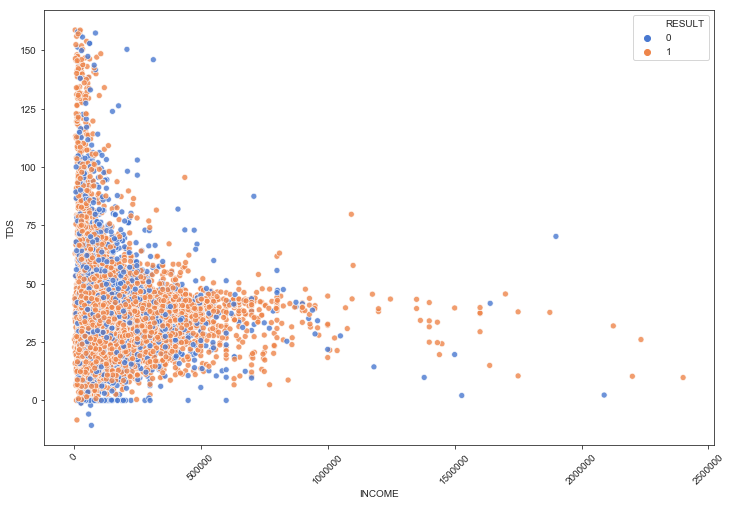

In [26]:
scatter_plot('INCOME', 'TDS', 'RESULT', df)

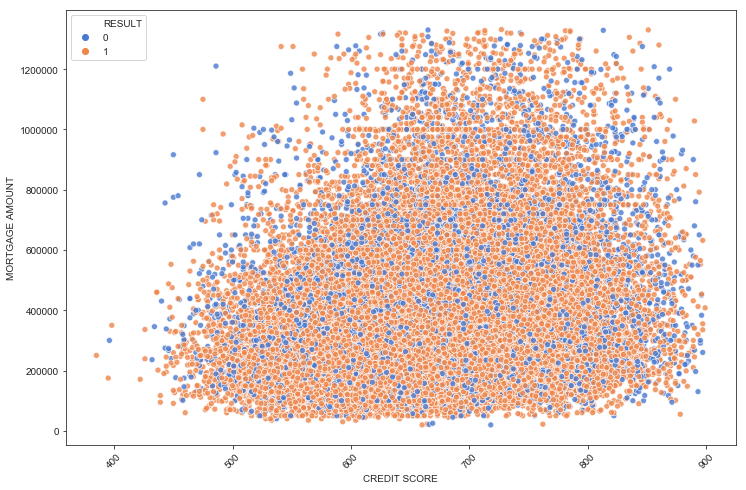

In [27]:
scatter_plot('CREDIT SCORE', 'MORTGAGE AMOUNT', 'RESULT', df[df['CREDIT SCORE'] > 0])

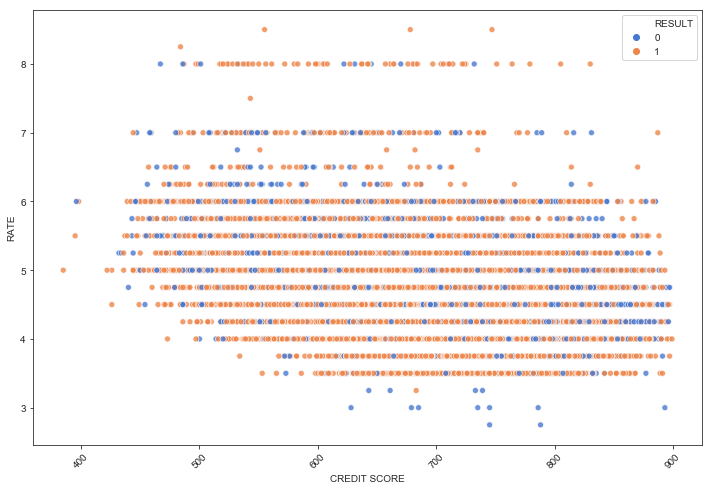

In [28]:
scatter_plot('CREDIT SCORE', 'RATE', 'RESULT', df[df['CREDIT SCORE'] > 0])

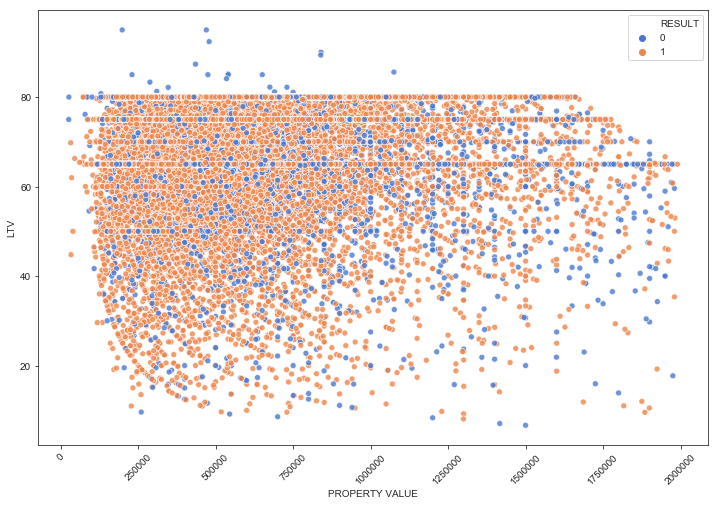

In [29]:
scatter_plot('PROPERTY VALUE', 'LTV', 'RESULT', df)

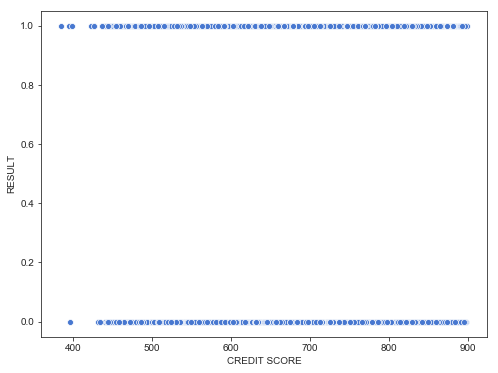

In [30]:
plt.figure(figsize=(8,6))
data = df
x1 = df[df['CREDIT SCORE'] > 0]['CREDIT SCORE']
y1 = df[df['CREDIT SCORE'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

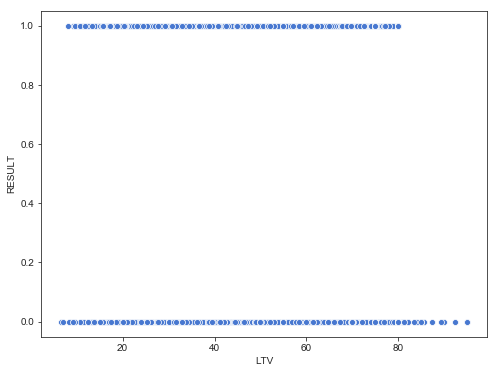

In [31]:
plt.figure(figsize=(8,6))
data = df
x1 = df[df['LTV'] > 0]['LTV']
y1 = df[df['LTV'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

In [32]:
#Territory Breakdown
df.groupby('TERRITORY')['RESULT'].value_counts()

TERRITORY  RESULT
A          1           326
           0            92
B          1           221
           0            92
C          1             9
           0             6
E          1            75
           0            27
G          1            59
           0            31
H          1           573
           0           263
J          1           572
           0           240
K          1          1839
           0           600
L          1         18799
           0          4533
M          1          7628
           0          1736
N          1          1988
           0           545
P          1           161
           0            54
R          1           220
           0            74
T          1           950
           0           294
V          1          1793
           0           677
W          0             1
X          0             8
           1             1
Name: RESULT, dtype: int64

## ENCODING & FEATURE ENGINEERING

In [33]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'PROPERTY_VAL_DELTA', 'TERRITORY', 'URBAN'],
      dtype='object')

In [34]:
# To help avoid overfitting, dropped observations with rare values in certain columns

columns_to_check = ['TERRITORY', 'INCOME TYPE', 'RATE', 'AMORTIZATION']
thresh = 5

def remove_low_value_counts(df):
    
    for c in columns_to_check:
        
        df = df[df.groupby(c)[c].transform('size') > thresh]
        
    return df

df = remove_low_value_counts(df)

In [35]:
# After Removing Low Value Counts
print(f'Total Observations: {len(df)}')

Total Observations: 44464


In [36]:
drop_first = False

def encode(df):
    
    le = LabelEncoder()
    
    # Encode Age Range
    df['AGE RANGE'] = le.fit_transform(df['AGE RANGE'])
    df['AGE RANGE'] = df['AGE RANGE'].apply(lambda x: x + 1)
    df['AGE RANGE'] = df['AGE RANGE'].replace({11:0})
    
    #Encode Mortgage Purpose
    df['MORTGAGE PURPOSE'] = le.fit_transform(df['MORTGAGE PURPOSE'])
    
    #Encode Payment Frequency based on Monthly or Not
    df['PAYMENT FREQUENCY'] = np.where(df['PAYMENT FREQUENCY'] == 'Monthly', 1, 0)
    
    #Encode Gender
    df['GENDER'] = le.fit_transform(df['GENDER'])
    
    #Encode Term
    df['TERM'] = le.fit_transform(df['TERM'])
    
    # Territory - High Correlated Territories (V & L) equal 1, rest 0
    #df['TERRITORY'] = np.where((df['TERRITORY'] == 'V') | (df['TERRITORY'] == 'L'), 1, 0)
    
    #Territory Dummy Variables
    df_temp = pd.get_dummies(df['TERRITORY'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df = df.drop(['TERRITORY'], axis=1)
    
    #Encode NAICS based on whether 55 or Not
    df['NAICS CODE'] = np.where(df['NAICS CODE'] == '55', 1, 0)
    
    # Drop Property Types Except for Single Detached
    #df['PROPERTY TYPE'] = np.where(df['PROPERTY TYPE'] == 'Single Detached', 1, 0)
    
    #Property Type Dummy Variables
    df_temp = pd.get_dummies(df['PROPERTY TYPE'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df = df.drop(['PROPERTY TYPE'], axis=1)
    
    #Encode Amortization
    df['AMORTIZATION'] = le.fit_transform(df['AMORTIZATION'])
    
    return df

df = encode(df)

In [37]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'TERM', 'AGE RANGE', 'GENDER', 'INCOME',
       'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'PROPERTY_VAL_DELTA', 'URBAN', 'A', 'B', 'C', 'E', 'G', 'H', 'J', 'K',
       'L', 'M', 'N', 'P', 'R', 'T', 'V', 'X', 'Duplex', 'Fourplex',
       'High Rise', 'Semi-Detached', 'Single Detached',
       'Townhouse Condominium', 'Townhouse Freehold', 'Triplex'],
      dtype='object')

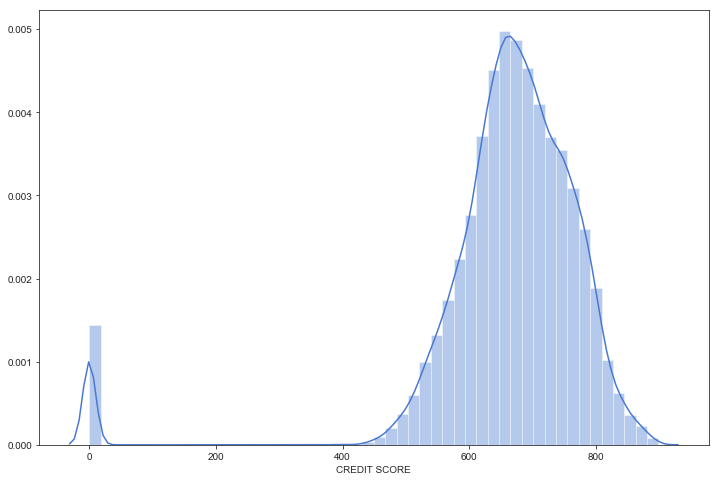

In [38]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

In [39]:
def add_features(df):
    
    df['ZERO SCORE'] = np.where(df['CREDIT SCORE'] == 0, 1, 0)
    df['GDS_ZERO'] = np.where(df['GDS'] == 0, 1, 0)
    df['TDS_ZERO'] = np.where(df['TDS'] == 0, 1, 0)
    
    df['PMT_INCOME_RATIO'] =  ((df['INCOME'] / 12) / df['MORTGAGE PAYMENT']) * 100
    
    df['MORTGAGE CONSTANT'] = ((df['MORTGAGE PAYMENT'] * 12) / df['MORTGAGE AMOUNT']) * 100
    df['AGE_ADJUSTED_INCOME'] = df['INCOME'] / (df['AGE RANGE']+ 1)
    df['AGE_ADJUSTED_CREDIT'] = df['CREDIT SCORE'] / (df['AGE RANGE']+ 1)
    
    df = df.drop(['INCOME TYPE', 'MORTGAGE PAYMENT'], axis=1)
                             
    return df

df = add_features(df)

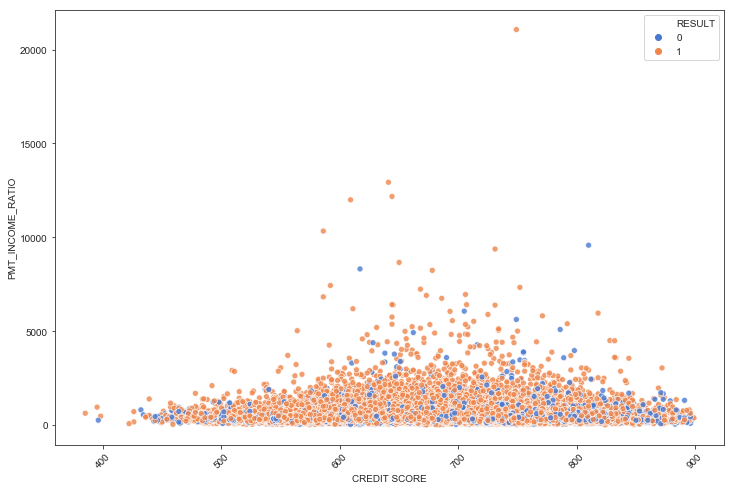

In [40]:
scatter_plot('CREDIT SCORE', 'PMT_INCOME_RATIO',  'RESULT', df[df['CREDIT SCORE'] > 0])

In [41]:
print(f'Total Observations: {len(df)}')

Total Observations: 44464


In [42]:
def remove_outliers_2(df):
    
    df = df[df['MORTGAGE CONSTANT'] < 15]
    
    return df

df = remove_outliers_2(df)
df['RESULT'].value_counts()
print(f'Total Observations: {len(df)}')

1    35160
0     9245
Name: RESULT, dtype: int64

Total Observations: 44405


In [43]:
def add_natural_logs(df):
    
    cols_to_log = ['PROPERTY VALUE', 'MORTGAGE AMOUNT', 'INCOME']
    
    for col in cols_to_log:
        
        df[col] = np.log(df[col])
        
    return df

df = add_natural_logs(df)

In [44]:
apply_interactions = True

def add_interactions(df):
    
    if apply_interactions:
        
        #Interactions with 'Rate'
        df['RATE_X_CREDIT_SCORE'] = df['RATE'] * df['CREDIT SCORE']
        df['RATE_X_PMT_INCOME_RATIO'] = df['RATE'] * df['PMT_INCOME_RATIO']
        df['RATE_X_LTV'] = df['RATE'] * df['LTV']
    
        df['TDS_X_INCOME'] = df['TDS'] * df['INCOME']
        df['TDS_X_PROPERTY_VAL'] = df['TDS'] * df['PROPERTY VALUE']
        
        df['AGE_ADJUSTED_INCOME_X_CREDIT_SCORE'] = df['AGE_ADJUSTED_INCOME'] * df['CREDIT SCORE']
        
    
        return df
    
    else:
        
        return df

df = add_interactions(df)

In [45]:
apply_poly = False

def add_polynomials(df):
    
    if apply_poly:
        
        cols_to_poly = ['GDS', 'TDS', 'LTV', 'PROPERTY VALUE', 'PROPERTY_VAL_DELTA', 'INCOME_RATIO', 'CREDIT SCORE', 'AMORTIZATION']

        for col in cols_to_poly:

            df[col+'_2'] = df[col] ** 2
            df[col+'_3'] = df[col] ** 3

        return df
    
    else:
        
        return df

df = add_polynomials(df)

In [46]:
len(df.columns)

55

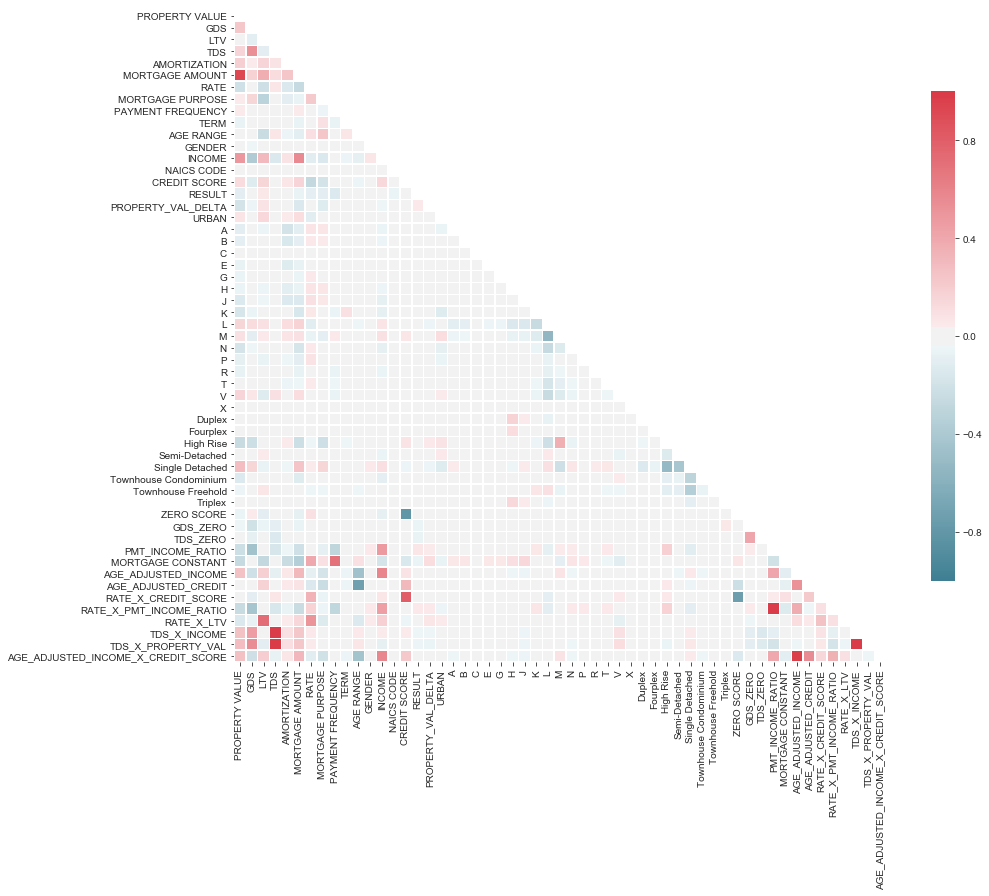

In [47]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [48]:
abs(df.corr()['RESULT']).sort_values(ascending=False)

RESULT                                1.000000
PAYMENT FREQUENCY                     0.133279
MORTGAGE PURPOSE                      0.100129
PROPERTY VALUE                        0.094131
RATE                                  0.088422
MORTGAGE AMOUNT                       0.069282
TDS_ZERO                              0.063427
PMT_INCOME_RATIO                      0.062659
GDS_ZERO                              0.061060
NAICS CODE                            0.060070
LTV                                   0.058648
MORTGAGE CONSTANT                     0.056377
RATE_X_PMT_INCOME_RATIO               0.050137
PROPERTY_VAL_DELTA                    0.047959
TDS_X_PROPERTY_VAL                    0.047757
TDS_X_INCOME                          0.041408
V                                     0.038696
TDS                                   0.036611
L                                     0.036600
H                                     0.036103
RATE_X_CREDIT_SCORE                   0.035971
J            

# Scrub / Encode / Add Features DF

In [49]:
data = pd.read_csv('CAX_MortgageModeling_Train.csv')
dfx = pd.DataFrame(data)

def scrub_encode_add_features(df):
    
    x1 = remove_outliers_2(add_features(encode(remove_low_value_counts(remove_outliers(clean_data(encode_target(df)))))))
    x2 = add_polynomials(add_interactions(add_natural_logs(x1)))
    
    return x2

df = scrub_encode_add_features(dfx)

# Helper Functions

## Scoring Function

In [50]:
# Scorer Function that takes in Classifier as an argument with test data
def score_model(clf, X_train, X_test, y_train, y_test):
    
    print('Model Scores for: ', '\n\n','---->', clf, '\n')
    print('Train Accuracy score: ', accuracy_score(y_train, clf.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, clf.predict(X_test)),'\n')
    print('Train F1 score: ', f1_score(y_train, clf.predict(X_train)))
    print('Test F1 score: ', f1_score(y_test, clf.predict(X_test)), '\n')
    print("Testing Precision Score: ", precision_score(y_test, clf.predict(X_test)))
    print("Testing Recall Score: ", recall_score(y_test, clf.predict(X_test)))
    print('Test AUC score: ', roc_auc_score(y_test, clf.predict(X_test)), '\n')
    print('Classification Report: ', '\n', classification_report(y_test, clf.predict(X_test)), '\n')
    
    return clf

## Confusion Matrix Function

In [51]:
#Confusion Matrix Fuction
def confusion_func(clf, X_test, y_test):
    
    sns.set_style('whitegrid')
    plt.figure(figsize = (9, 9))
    plt.title(f'Confusion Matrix - {clf.__class__.__name__}')
    
    cm_lr = confusion_matrix(y_test, clf.predict(X_test))
    
    return sns.heatmap(cm_lr, annot = True, fmt = 'g', linewidths = .5, square = True, cmap = "Blues")

## ROC Curve Function

In [52]:
def ROC_func(clf, X_test, y_test):
    
    y_pred_prob = clf.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC Curve - {clf.__class__.__name__}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

    print('AUC (pred_proba): ', roc_auc_score(y_test, y_pred_prob))

## Score / Confusion / ROC Curve Helper

In [53]:
def all_in_on_scorer(clf, X_train, X_test, y_train, y_test):
    
    clf = score_model(clf, X_train, X_test, y_train, y_test)
    cf = confusion_func(clf, X_test, y_test)
    roc = ROC_func(clf, X_test, y_test)
    
    return clf

## Feature Importance Helper

In [54]:
def print_feature_importance(clf, X_train, top_n=50):
    
    title = f'Feature Importance - {clf.__class__.__name__}'
    figsize = (10,10)
    
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()

# Test / Train / Split

In [55]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [56]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]= "True"

In [57]:
def prepare_data(df):
    
    #Separate Target & Feature
    y = df['RESULT']
    features = df.drop(['RESULT'], axis=1)
    
    #Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=17, test_size=0.20)
    
    #Scale Data
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train = pd.DataFrame(data = X_scaler.transform(X_train), columns=features.columns)
    X_test = pd.DataFrame(data = X_scaler.transform(X_test), columns=features.columns)

    return X_train, X_test, y_train, y_test, y, features, X_scaler

X_train, X_test, y_train, y_test, y, features, X_scaler = prepare_data(df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## Random Over Sample

In [58]:
def oversample_random(X_train, y_train):
    
    ros = RandomOverSampler(random_state=1)
    X_res, y_res = ros.fit_sample(X_train, y_train)
    
    X_res = pd.DataFrame(X_res, columns=X_train.columns)
    
    print(f'Before ROS: {Counter(y_train)}')
    print(f'After ROS: {Counter(y_res)}')
    
    return X_res, y_res

X_train_ros, y_train_ros = oversample_random(X_train, y_train)

Before ROS: Counter({1: 28076, 0: 7448})
After ROS: Counter({1: 28076, 0: 28076})


# Models

## Grid Search - Helper Function

In [59]:
def run_grid_search(clf, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'roc_auc'
    
    grid = GridSearchCV(clf, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train_ros, y_train_ros)
    
    best_grid_clf = grid.best_estimator_
    
    print('Grid Search: ', clf.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_clf

## Decision Tree

In [60]:
def decision_tree_model(X_train, y_train):
    
    criterion = 'entropy'
    min_impurity_decrease = 0.001
    max_depth = 25
    
    dt_clf = DecisionTreeClassifier(max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
    decision_tree_clf = dt_clf.fit(X_train, y_train)
    
    return decision_tree_clf

In [61]:
# Train Model
decision_tree_trainer = decision_tree_model(X_train_ros, y_train_ros)

Model Scores for:  

 ----> DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Train Accuracy score:  0.6277069383103007
Test Accuracy score:  0.674923995045603 

Train F1 score:  0.6591001744859187
Test F1 score:  0.7783833576418208 

Testing Precision Score:  0.8531044926804644
Testing Recall Score:  0.7156973461321288
Test AUC score:  0.6149438316637271 

Classification Report:  
               precision    recall  f1-score   support

           0       0.31      0.51      0.39      1797
           1       0.85      0.72      0.78      7084

   micro avg       0.67      0.67      0.67      8881
   macro avg       0.58      0.61      0.58      8881
weighted avg       0.74      0.67      0

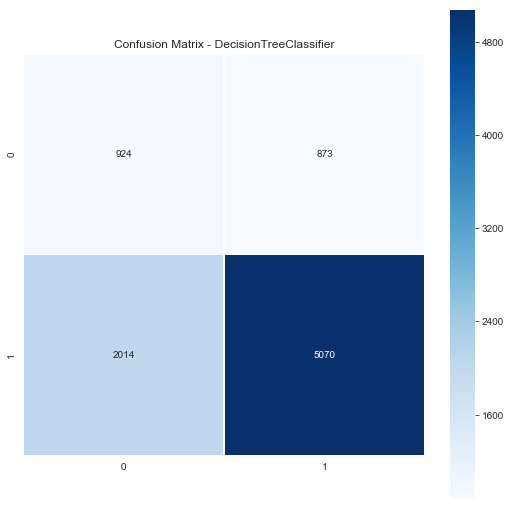

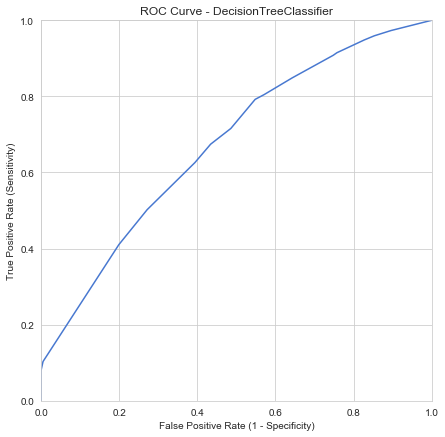

In [62]:
#Score Model
clf_dt = all_in_on_scorer(decision_tree_trainer, X_train_ros, X_test, y_train_ros, y_test)

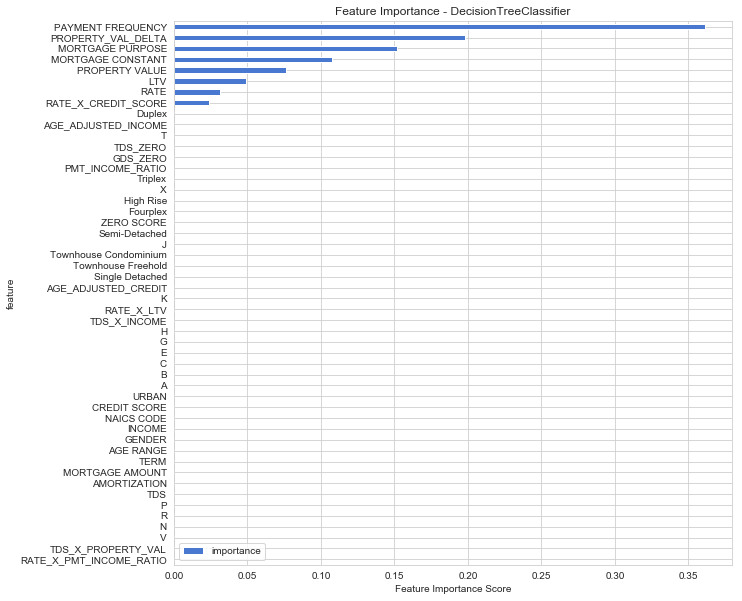

In [63]:
print_feature_importance(clf_dt, X_train)

## Ada Boost

In [64]:
# Create AdaBoost Instance with Decision Tree Base Classifier
def ada_boost(clf, X_train, y_train):

    abc_dt =AdaBoostClassifier(n_estimators=200, base_estimator=clf, learning_rate=0.015)
    ada_dt = abc_dt.fit(X_train, y_train)
    
    return ada_dt

In [65]:
#Train Model
ada_dt = ada_boost(clf_dt, X_train_ros, y_train_ros)

Model Scores for:  

 ----> AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.015, n_estimators=200, random_state=None) 

Train Accuracy score:  0.6661383387947001
Test Accuracy score:  0.6547686071388357 

Train F1 score:  0.6618933395855503
Test F1 score:  0.7502036825810656 

Testing Precision Score:  0.8870905587668594
Testing Recall Score:  0.6499153020892151
Test AUC score:  0.6619081240551807 

Classification Report:  
               precision    recall  f1-score   support

           0       0.33      0.67      0.44      1797
           1       0.89      0.65      0.75      7084

   micro avg 

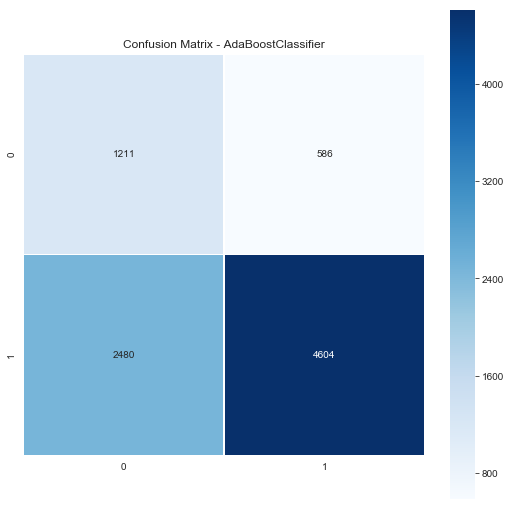

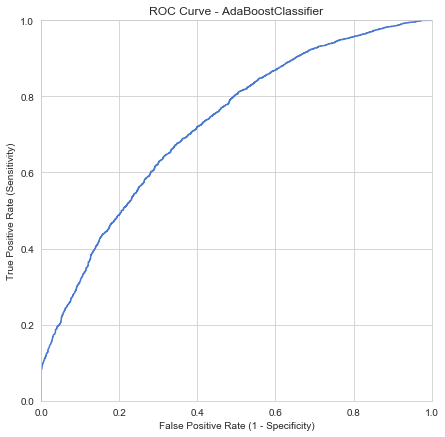

In [66]:
#Score Model
clf_dt_ada = all_in_on_scorer(ada_dt, X_train_ros, X_test, y_train_ros, y_test)

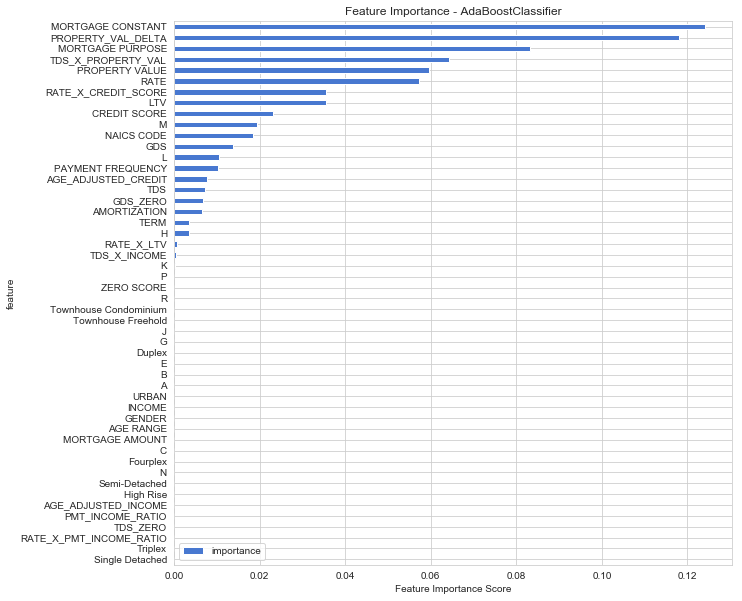

In [67]:
print_feature_importance(clf_dt_ada, X_train)

In [68]:
# Grid Search - AdaBooster
params = {'base_estimator__criterion' : ['gini', 'entropy'],
          'base_estimator__max_depth' :   [15, 20, 25],
          'n_estimators': [100, 150, 200],
          'learning_rate': [0.005, 0.01, 0.015]
        }

ada_boost_clf = AdaBoostClassifier(base_estimator = clf_dt)

ada_boost_clf_grid = run_grid_search(ada_boost_clf, params, X_train_ros, y_train_ros)

## Random Forest Classifier

In [69]:
def rfc_model(X_train, y_train):
    
    criterion = 'gini'
    max_features = 0.15
    n_estimators = 350
    min_samples_leaf = 5
    max_depth = 30
    
    rfc = RandomForestClassifier(criterion=criterion, max_features=max_features, n_estimators=n_estimators, \
                                 min_samples_leaf=min_samples_leaf, random_state=1)
    rfc_clf = rfc.fit(X_train, y_train)
    
    return rfc_clf

In [70]:
# Train Model - ROS
rfc_trainer = rfc_model(X_train_ros, y_train_ros)

Model Scores for:  

 ----> RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False) 

Train Accuracy score:  0.9948354466448212
Test Accuracy score:  0.7927035243778854 

Train F1 score:  0.9948429775580611
Test F1 score:  0.8750593824228028 

Testing Precision Score:  0.8426349496797805
Testing Recall Score:  0.9100790513833992
Test AUC score:  0.6200367432765632 

Classification Report:  
               precision    recall  f1-score   support

           0       0.48      0.33      0.39      1797
           1       0.84      0.91      0.88      7084

   micro avg       0.79      0.79      0.79      8881
   macro avg       0.66      0.62  

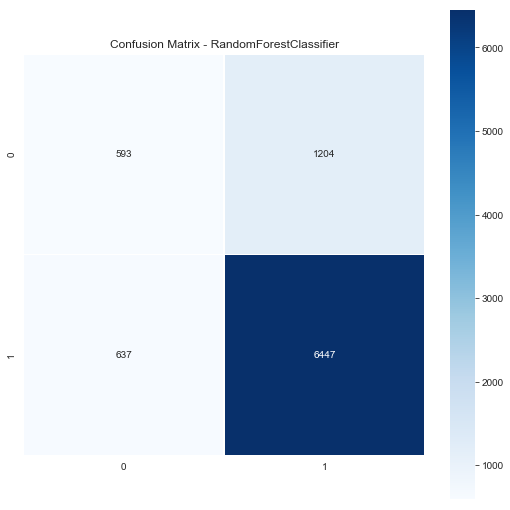

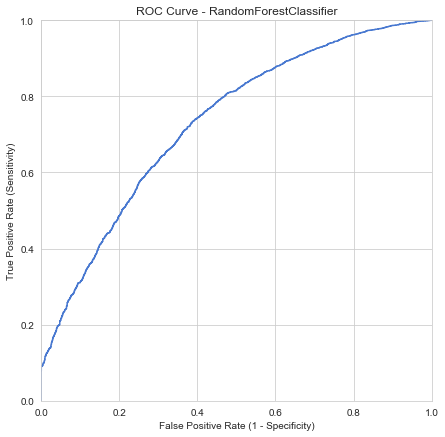

In [71]:
#Score Model
clf_rfc = all_in_on_scorer(rfc_trainer, X_train_ros, X_test, y_train_ros, y_test)

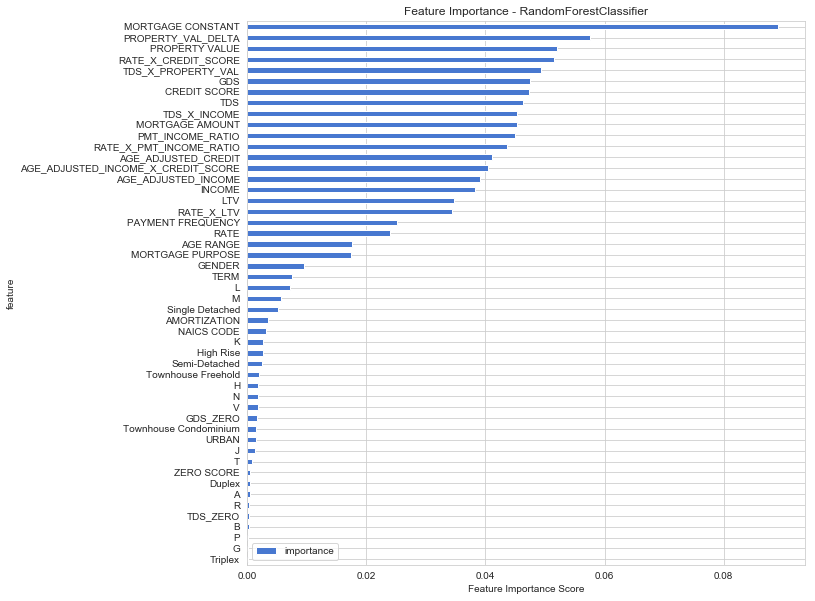

In [72]:
print_feature_importance(clf_rfc, X_train)

In [73]:
# Grid Search - RFC
params = {'base_estimator__criterion' : ['gini', 'entropy'],
          'base_estimator__max_features' :   [0.15, 0.25, 0.35],
          'base_estimator__n_estimators': [150, 250, 350, 450],
          'base_estimator__max_depth': [30, 40, 50]
        }

ada_boost_rfc = AdaBoostClassifier(base_estimator = clf_rfc)

ada_rfc_grid = run_grid_search(ada_boost_rfc, params, X_train_ros, y_train_ros)

## XGBoost

In [74]:
def xgb_model(X_train, y_train):
    
    objective = 'binary:logistic'
    colsample_bytree = 0.75
    learning_rate = 0.10
    max_depth = 5
    alpha = 10
    n_estimators = 500
    scale_pos_weight = .25

    xgb_clf = XGBClassifier(objective=objective, colsample_bytree=colsample_bytree, learning_rate=learning_rate, \
                                max_depth=max_depth, alpha=alpha, n_estimators=n_estimators)
    
    xgb_clf = xgb_clf.fit(X_train, y_train)
    
    return xgb_clf

In [75]:
# Train Model
xgb_trainer = xgb_model(X_train_ros, y_train_ros)

Model Scores for:  

 ----> XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) 

Train Accuracy score:  0.8434606069240632
Test Accuracy score:  0.7449611530233082 

Train F1 score:  0.8454750017579636
Test F1 score:  0.8326313455996452 

Testing Precision Score:  0.8736238176461467
Testing Recall Score:  0.795313382269904
Test AUC score:  0.670889857523377 

Classification Report:  
               precision    recall  f1-score   support

           0       0.40      0.55      0.46      1797
           1       0.87      0.80      0.83      7084

   micro avg       0.74      0.74      0.74      8881
   macro avg       0.64      0.67      0.65 

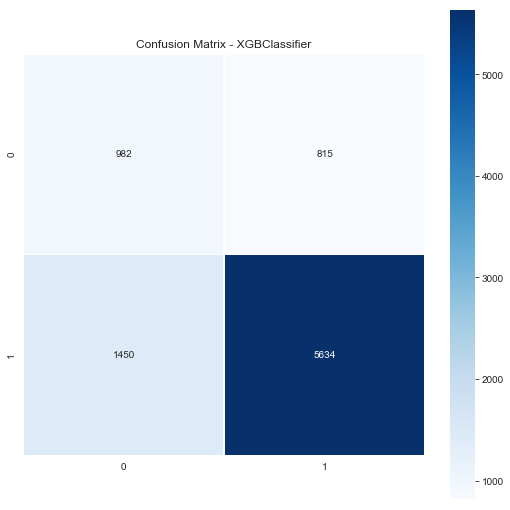

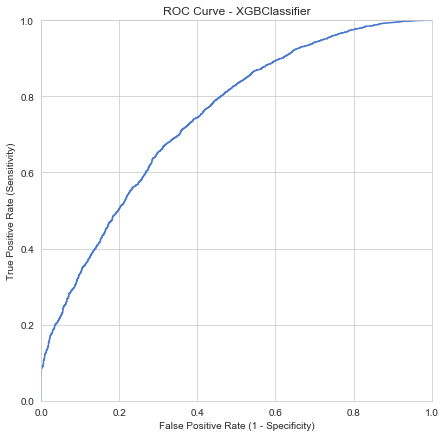

In [76]:
# Convert column names back to original
X_test = X_test[X_train_ros.columns]

# Scoring Function
clf_xgb = all_in_on_scorer(xgb_trainer, X_train_ros, X_test, y_train_ros, y_test)

In [ ]:
# Grid Search - XGB
params = {'base_estimator__colsample_bytree' : [0.65, 0.75, 0.85],
          'base_estimator__n_estimators': [250, 350, 450],
          'base_estimator__learning_rate': [0.05, 0.15, 0.25]
        }

ada_boost_xgb = AdaBoostClassifier(base_estimator = clf_xgb)

ada_rfc_grid = run_grid_search(ada_boost_xgb, params, X_train_ros, y_train_ros)

# Voting Classifier

In [78]:
clf1 = clf_rfc # Random Forest Classifier trained on ROS data
clf2 = clf_xgb # XGBoost Classifier trained on ROS data
clf3 = clf_dt_ada #Adaboost with DT base classifier

voting_clf = VotingClassifier(estimators=[('rfc', clf1), ('xgb', clf2), ('dt_ada', clf3)], voting='soft', weights=[1, 1, 1])
voting_clf = voting_clf.fit(X_train_ros, y_train_ros)

Model Scores for:  

 ----> VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_wei...
            splitter='best'),
          learning_rate=0.015, n_estimators=200, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1, 1]) 

Train Accuracy score:  0.9532162701239493
Test Accuracy score:  0.77772773336336 

Train F1 score:  0.9527917048538106
Test F1 score:  0.8593014967925873 

Testing Precision Score:  0.8678376043766196
Testing Recall Score:  0.8509316770186336
Test AUC score:  0.6700401289934571 

Classification Report:  
               precision    recall  f1-score   support

           0       0.45      0.49      0.47      1797
           1       0.87      0.85      0.86

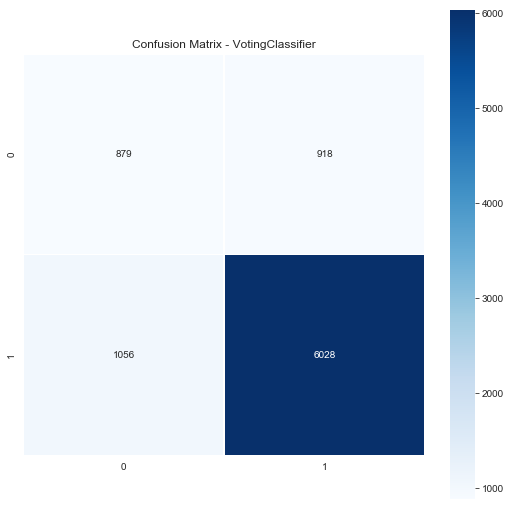

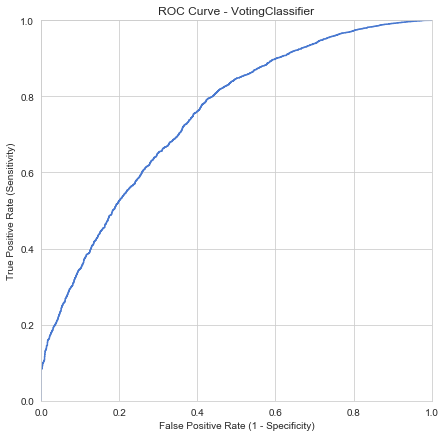

In [79]:
#Score Model
voting_clf = all_in_on_scorer(voting_clf, X_train_ros, X_test, y_train_ros, y_test)

## Run on Test Set for Competition

In [ ]:
file = pd.read_csv('CAX_MortgageModeling_Test.csv')
submission = pd.read_csv('CAX_MortgageModeling_SubmissionFormat.csv')
test_df = pd.DataFrame(file)
submission_df = pd.DataFrame(submission)
submission_df.set_index('Unique_ID', inplace=True)

test_df = test_df.drop(['RESULT'], axis=1)

test_df = add_interactions(add_natural_logs(add_features(encode(clean_data(test_df)))))

In [ ]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( test_df.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_df[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
test_df = test_df[X_train.columns]

# Scale
test_df = pd.DataFrame(data=X_scaler.transform(test_df), columns=test_df.columns)

In [ ]:
# Score model
print('Modeled Funded: ', (voting_clf.predict(test_df) == 1).sum())
print('Modeled Not Funded: ', (voting_clf.predict(test_df) == 0).sum())

In [ ]:
rfc_submission = voting_clf.predict(test_df)

submission_df['Result_Predicted'] = rfc_submission
submission_df['Result_Predicted'] = submission_df['Result_Predicted'].replace({1: 'FUNDED', 0: 'NOT FUNDED'})
submission_df['Result_Predicted'].value_counts()